In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
# !pip install tensorflow --user
# !pip install keras
# !pip install daytime
# !pip install torch

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score,precision_score
RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]

In [5]:
dataset = pd.read_csv("creditcard.csv")
#dataset.head
# print(list(dataset.columns))
# dataset.describe()

In [6]:
#check for any nullvalues
print("Any nulls in the dataset ",dataset.isnull().values.any() )
print('-------')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values ",dataset.Class.unique())
#0 is for normal credit card transaction
#1 is for fraudulent credit card transaction
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort = True) )

Any nulls in the dataset  False
-------
No. of unique labels  2
Label values  [0 1]
-------
Break down of the Normal and Fraud Transactions
Class
0    284315
1       492
Name: count, dtype: int64


C:\Users\tejas\AppData\Local\Temp\ipykernel_14268\913997322.py:10: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(dataset['Class'], sort = True) )


C:\Users\tejas\AppData\Local\Temp\ipykernel_14268\3399164077.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(dataset['Class'], sort = True)


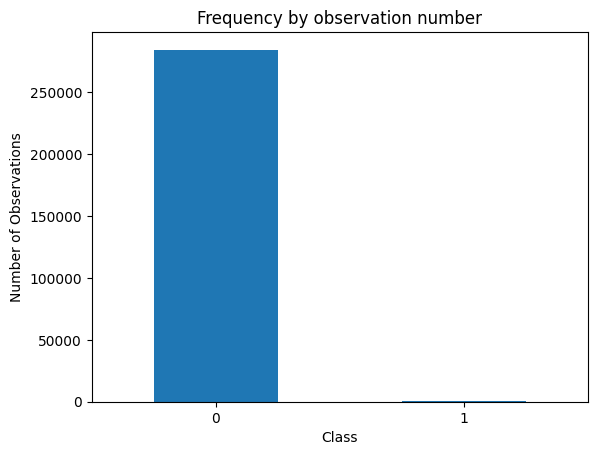

In [7]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

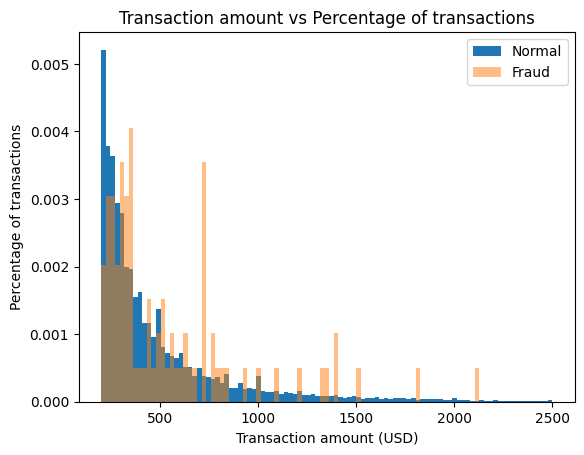

In [8]:
# Save the normal and fradulent transactions in separate dataframe
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]
#Visualize transactionamounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True,label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True,label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions");
plt.show()

In [9]:
'''Time and Amount are the columns that are not scaled, so applying
StandardScaler to only Amount and Time columns.
Normalizing the values between 0 and 1 did not work great for the dataset.'''

'Time and Amount are the columns that are not scaled, so applying\nStandardScaler to only Amount and Time columns.\nNormalizing the values between 0 and 1 did not work great for the dataset.'

In [10]:
sc=StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

In [11]:
'''The last column in the dataset is our target variable.'''
raw_data = dataset.values
# The last element contains if the transaction is normal which is represented by a 0 and if fraud then 1
labels = raw_data[:, -1]
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
data, labels, test_size=0.2, random_state=2021
)

In [12]:
'''Normalize the data to have a value between 0 and 1'''
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [13]:
'''Use only normal transactions to train the Autoencoder.
Normal data has a value of 0 in the target variable. Using the target variable 
to create a normal and fraud dataset.'''
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
#creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print(" No. of records in Fraud Train Data=",len(fraud_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Fraud Test Data=",len(fraud_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

 No. of records in Fraud Train Data= 389
 No. of records in Normal Train data= 227456
 No. of records in Fraud Test Data= 103
 No. of records in Normal Test data= 56859


In [14]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4
learning_rate = 1e-7

In [15]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",
activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           434 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,168 (4.56 KB)

 Trainable params: 1,168 (4.56 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
"""Define the callbacks for checkpoints and early stopping"""
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
mode='min', monitor='val_loss', verbose=2,save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
min_delta=0.0001,
patience=10,
verbose=1,
mode='min',
restore_best_weights=True)

In [17]:
#Compile the Autoencoder
autoencoder.compile(metrics=['accuracy'],
loss='mean_squared_error',
optimizer='adam')

In [18]:
#Train the Autoencoder
history = autoencoder.fit(normal_train_data, normal_train_data,
epochs=nb_epoch,
batch_size=batch_size,
shuffle=True,
validation_data=(test_data, test_data),
verbose=1,
callbacks=[cp, early_stop]
).history

Epoch 1/50
3546/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0547 - loss: 0.0196
Epoch 1: val_loss improved from None to 0.00013, saving model to autoencoder_fraud.h5


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.0588 - loss: 0.0041 - val_accuracy: 0.0263 - val_loss: 1.2727e-04
Epoch 2/50
3535/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0638 - loss: 1.9173e-05
Epoch 2: val_loss improved from 0.00013 to 0.00012, saving model to autoencoder_fraud.h5


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.0645 - loss: 1.9264e-05 - val_accuracy: 0.0371 - val_loss: 1.1630e-04
Epoch 3/50
3552/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0627 - loss: 1.9321e-05
Epoch 3: val_loss improved from 0.00012 to 0.00012, saving model to autoencoder_fraud.h5


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.0631 - loss: 1.9451e-05 - val_accuracy: 0.0263 - val_loss: 1.1528e-04
Epoch 4/50
3539/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0717 - loss: 1.9672e-05
Epoch 4: val_loss improved from 0.00012 to 0.00009, saving model to autoencoder_fraud.h5


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.0760 - loss: 1.9427e-05 - val_accuracy: 0.0251 - val_loss: 9.1769e-05
Epoch 5/50
3537/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1022 - loss: 1.8976e-05
Epoch 5: val_loss improved from 0.00009 to 0.00007, saving model to autoencoder_fraud.h5


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1239 - loss: 1.8926e-05 - val_accuracy: 0.0251 - val_loss: 6.9502e-05
Epoch 6/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1792 - loss: 1.8483e-05
Epoch 6: val_loss improved from 0.00007 to 0.00006, saving model to autoencoder_fraud.h5


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1859 - loss: 1.8217e-05 - val_accuracy: 0.0251 - val_loss: 5.7815e-05
Epoch 7/50
3533/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2012 - loss: 1.7905e-05
Epoch 7: val_loss improved from 0.00006 to 0.00005, saving model to autoencoder_fraud.h5


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2050 - loss: 1.7881e-05 - val_accuracy: 0.0251 - val_loss: 4.6389e-05
Epoch 8/50
3541/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2301 - loss: 1.7529e-05
Epoch 8: val_loss improved from 0.00005 to 0.00004, saving model to autoencoder_fraud.h5


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2359 - loss: 1.7462e-05 - val_accuracy: 0.0251 - val_loss: 4.1081e-05
Epoch 9/50
3550/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2482 - loss: 1.7258e-05
Epoch 9: val_loss did not improve from 0.00004
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.2489 - loss: 1.7300e-05 - val_accuracy: 0.0251 - val_loss: 4.7299e-05
Epoch 10/50
3537/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2519 - loss: 1.7449e-05
Epoch 10: val_loss did not improve from 0.00004
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2529 - loss: 1.7223e-05 - val_accuracy: 0.0251 - val_loss: 4.9115e-05
Epoch 11/50
3540/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2543 - loss: 1.7298e-05
Epoch 11: val_loss did not improve from 0.00004
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2555 - loss: 1.7130e-05 - val_accuracy: 0.0251 - val_loss: 5.1036e-05
Epoch 11: early stopping
Restoring model weights from the end of th

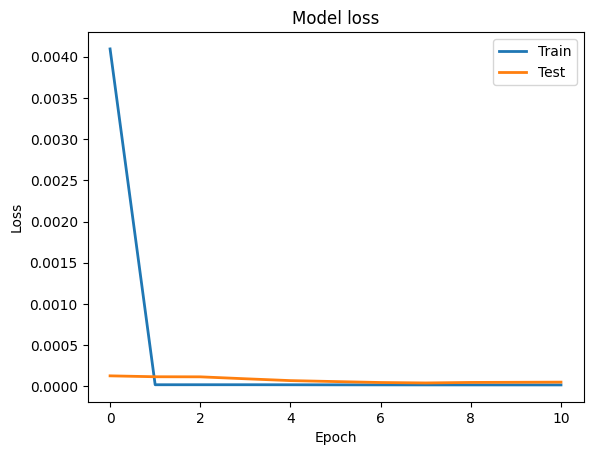

In [19]:
#Plot training and test loss
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [20]:
"""Detect Anomalies on test data
Anomalies are data points where the reconstruction loss is higher
To calculate the reconstruction loss on test data,
predict the test data and calculate the mean square error between the test data␣
↪and the reconstructed test data."""
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
'True_class': test_labels})

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


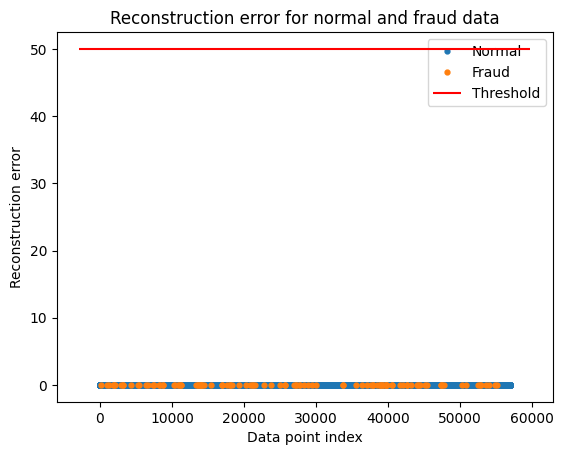

In [21]:
#Plotting the test data points and their respective reconstruction error sets a threshold value to visualize
#if the threshold value needs to be adjusted.
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5,linestyle='',
label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r",zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

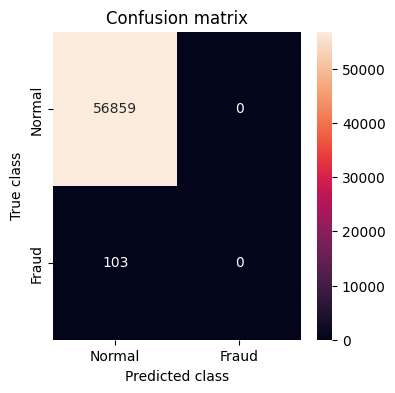

 Accuracy:  0.9981917769741231
 Recall:  0.0
 Precision:  0.0


c:\Users\tejas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [22]:
'''Detect anomalies as points where the reconstruction loss is greater than a␣
↪fixed threshold.
Here we see that a value of 52 for the threshold will be good.
Evaluating the performance of the anomaly detection'''
threshold_fixed =52
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True,fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

In [23]:
'''As our dataset is highly imbalanced, we see a high accuracy but a low recall
and precision.
Things to further improve precision and recall would add more relevant
features,
different architecture for autoencoder, different hyperparameters, or a
different algorithm.'''

'As our dataset is highly imbalanced, we see a high accuracy but a low recall\nand precision.\nThings to further improve precision and recall would add more relevant\nfeatures,\ndifferent architecture for autoencoder, different hyperparameters, or a\ndifferent algorithm.'